                            OLS Regression Results                            
Dep. Variable:     log_cited_by_count   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     1183.
Date:                Thu, 02 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:26:51   Log-Likelihood:                -11563.
No. Observations:                9816   AIC:                         2.314e+04
Df Residuals:                    9809   BIC:                         2.319e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

<Figure size 800x600 with 0 Axes>

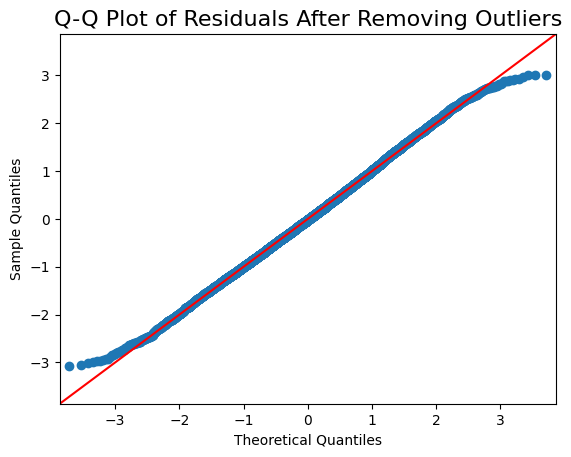

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Load the CSV file
# file_path = 'data_export.csv'
df = pd.read_csv("../../data/data_export.csv")

# Convert relevant columns to numeric and handle missing values
fields_to_convert = [
    "journal_h_index", "num_authors", "num_institutions",
    "cited_by_count", "publication_year", "avg_author_h_index", "max_author_h_index",
    "avg_institution_h_index", "max_institution_h_index", "avg_author_citations_past_5_years",
    "max_author_citations_past_5_years", "avg_institution_citations_past_5_years", 
    "max_institution_citations_past_5_years"
]
for field in fields_to_convert:
    df[field] = pd.to_numeric(df[field], errors="coerce").fillna(0)

# Convert publication_date to datetime
df["publication_date"] = pd.to_datetime(df["publication_date"], errors="coerce")

# Drop rows where cited_by_count is 0
df = df[df["cited_by_count"] > 0]

# Apply log transformation to all relevant variables
variables_to_log_transform = [
    "cited_by_count", 
    "avg_author_citations_past_5_years", 
    "avg_institution_citations_past_5_years", 
    "num_authors", 
    "num_institutions", 
    "journal_h_index"
]
for var in variables_to_log_transform:
    df[f"log_{var}"] = np.log1p(df[var])  # log(1 + variable)

# Calculate time since publication
df["years_since_publication"] = 2024 - df["publication_year"]

# Define independent (X) and dependent (y) variables using log-transformed versions where applicable
X = df[[
    "log_avg_author_citations_past_5_years", 
    "years_since_publication", 
    "log_journal_h_index", 
    "log_num_authors", 
    "log_num_institutions", 
    "log_avg_institution_citations_past_5_years",
]]
y = df["log_cited_by_count"]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the initial OLS regression model
model = sm.OLS(y, X).fit()

# Detect and remove outliers using standardized residuals
influence = model.get_influence()
standardized_residuals = influence.resid_studentized_internal

# Define a threshold for outliers (e.g., |residual| > 3)
outlier_threshold = 3
non_outliers = np.abs(standardized_residuals) <= outlier_threshold

# Filter out outliers from the dataset
df_cleaned = df[non_outliers]

# Re-define X and y with the cleaned dataset
X_cleaned = df_cleaned[[
    "log_avg_author_citations_past_5_years", 
    "years_since_publication", 
    "log_journal_h_index", 
    "log_num_authors", 
    "log_num_institutions", 
    "log_avg_institution_citations_past_5_years",
]]
y_cleaned = df_cleaned["log_cited_by_count"]

# Add a constant term to the independent variables
X_cleaned = sm.add_constant(X_cleaned)

# Fit the OLS regression model on the cleaned data
model_cleaned = sm.OLS(y_cleaned, X_cleaned).fit()

# Print the summary of the regression model
print(model_cleaned.summary())

# Generate a Q-Q plot of the residuals
plt.figure(figsize=(8, 6))
sm.qqplot(model_cleaned.resid, line='45', fit=True)
plt.title("Q-Q Plot of Residuals After Removing Outliers", fontsize=16)
plt.show()

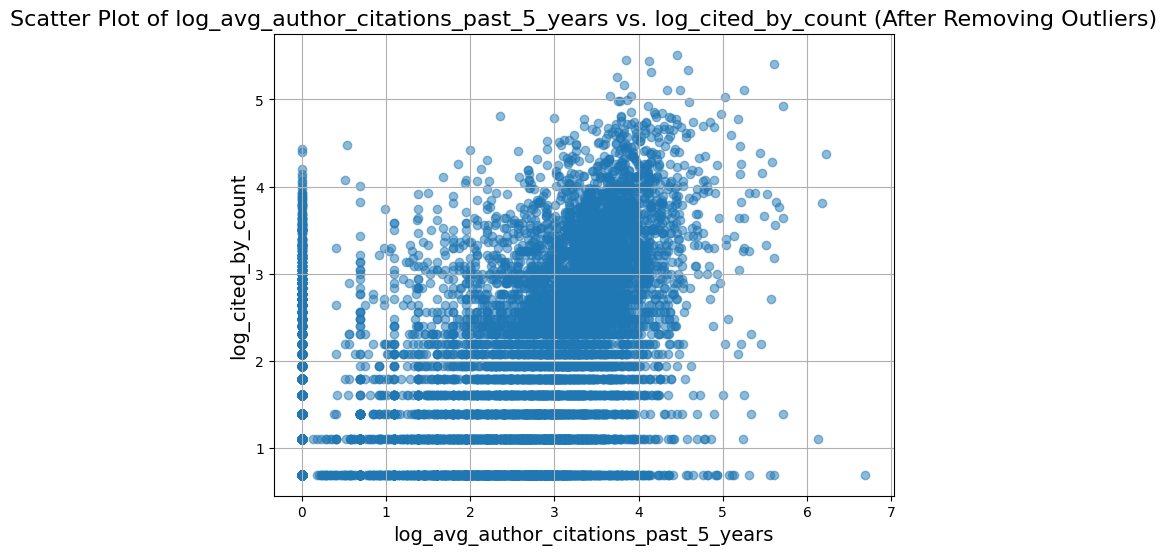

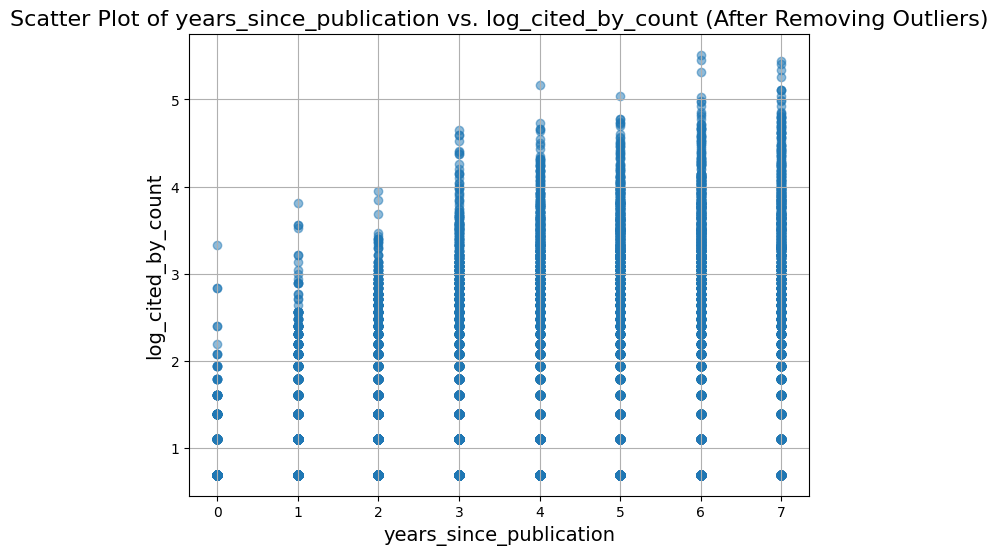

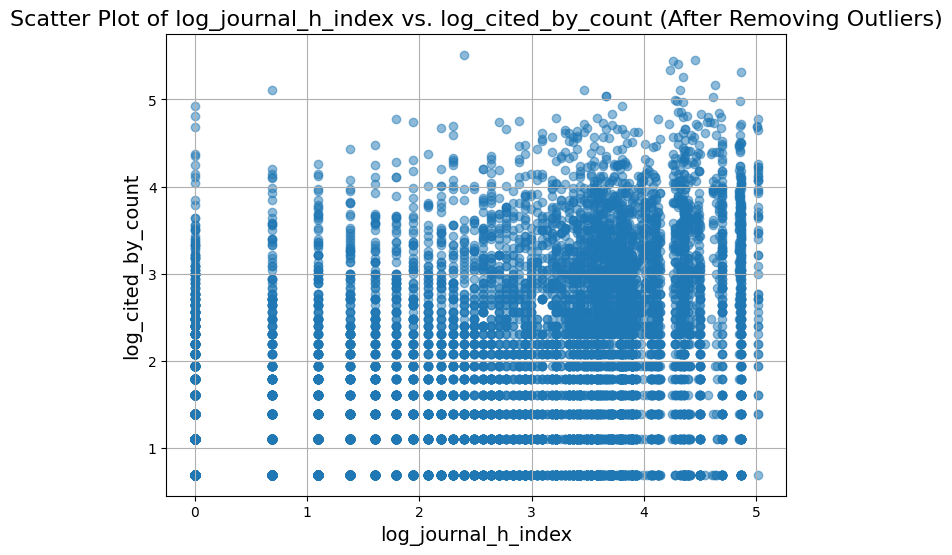

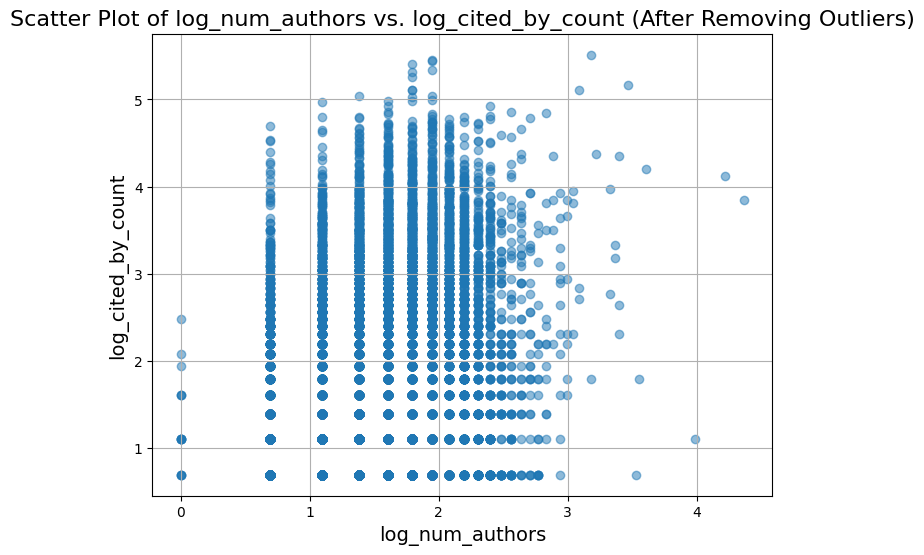

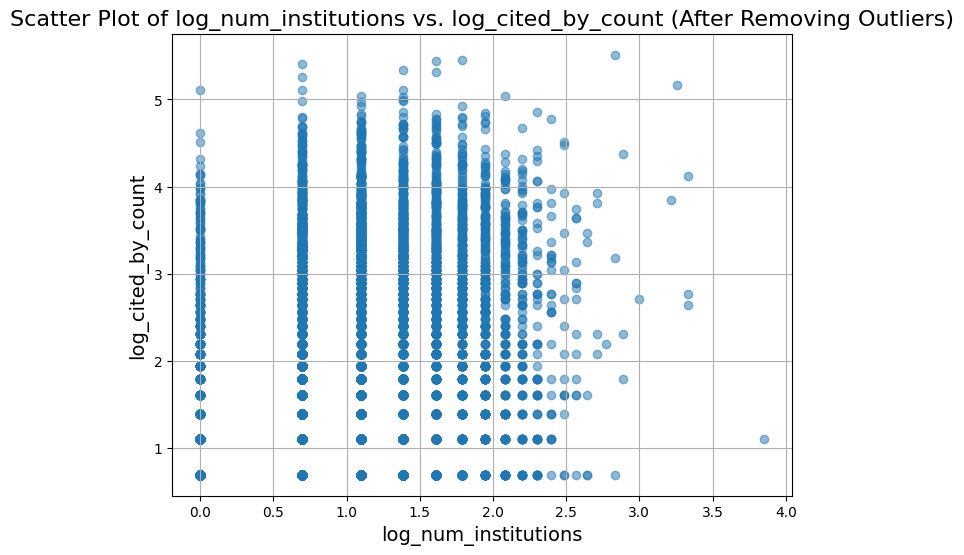

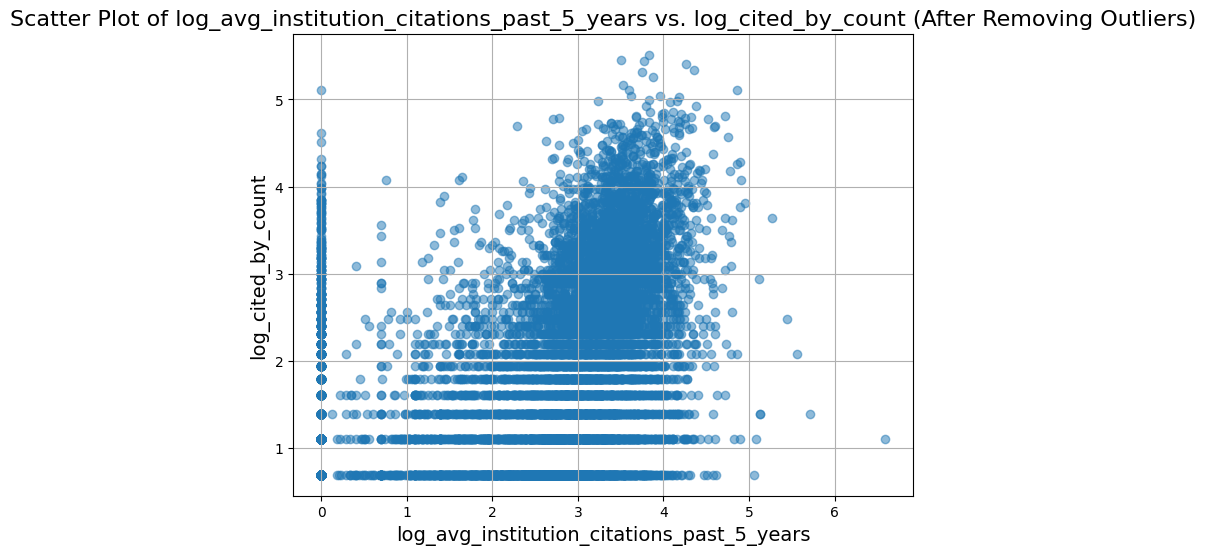

In [2]:
# Plot y_cleaned vs. each independent variable in X_cleaned
independent_vars = [
   "log_avg_author_citations_past_5_years", 
    "years_since_publication", 
    "log_journal_h_index", 
    "log_num_authors", 
    "log_num_institutions", 
    "log_avg_institution_citations_past_5_years",
]

for var in independent_vars:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_cleaned[var], y_cleaned, alpha=0.5)
    plt.title(f"Scatter Plot of {var} vs. log_cited_by_count (After Removing Outliers)", fontsize=16)
    plt.xlabel(var, fontsize=14)
    plt.ylabel("log_cited_by_count", fontsize=14)
    plt.grid(True)
    plt.show()

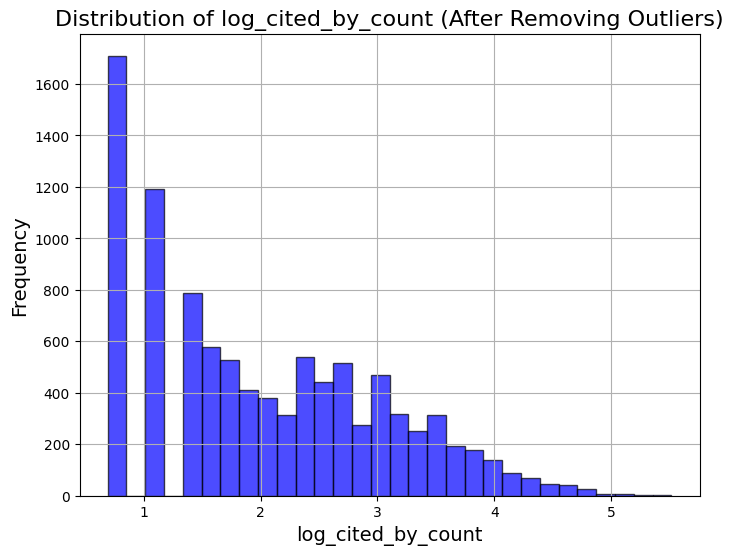

In [3]:
# Plot the distribution of y_cleaned to assess normality
plt.figure(figsize=(8, 6))
plt.hist(y_cleaned, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title("Distribution of log_cited_by_count (After Removing Outliers)", fontsize=16)
plt.xlabel("log_cited_by_count", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True)
plt.show()

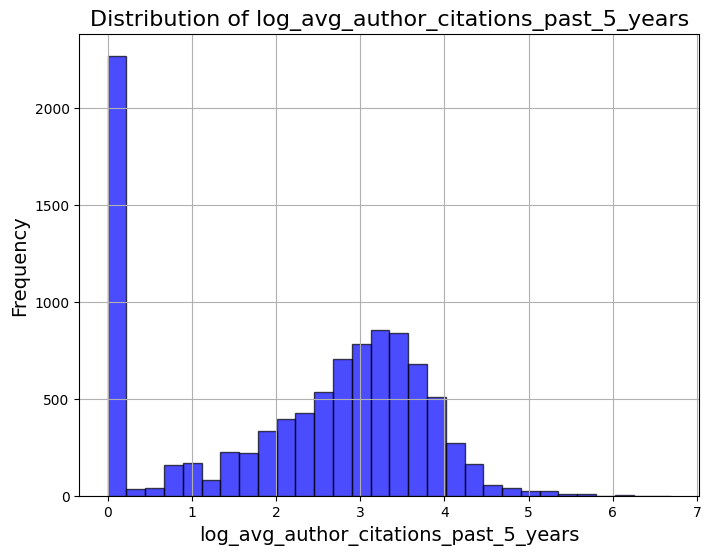

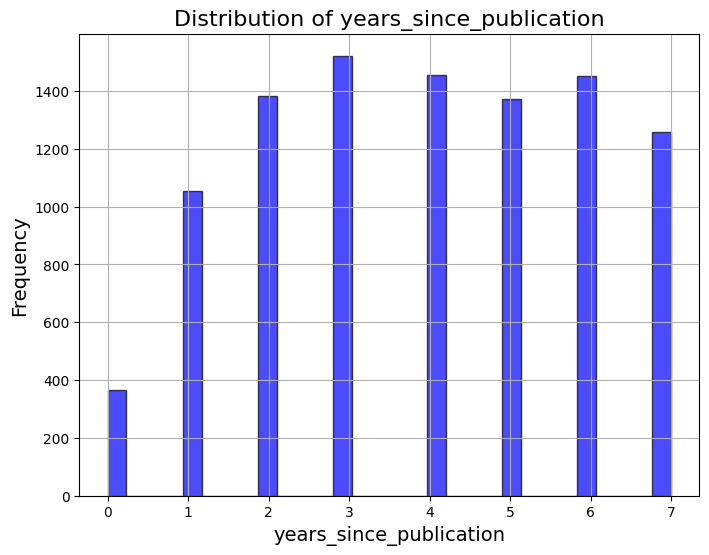

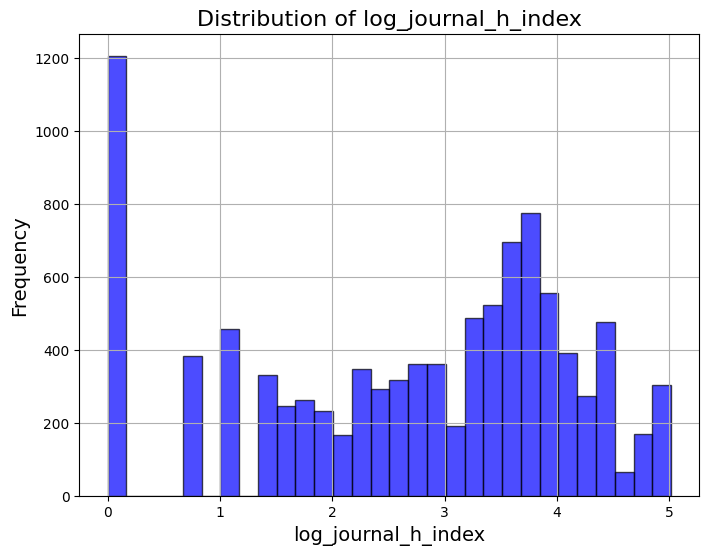

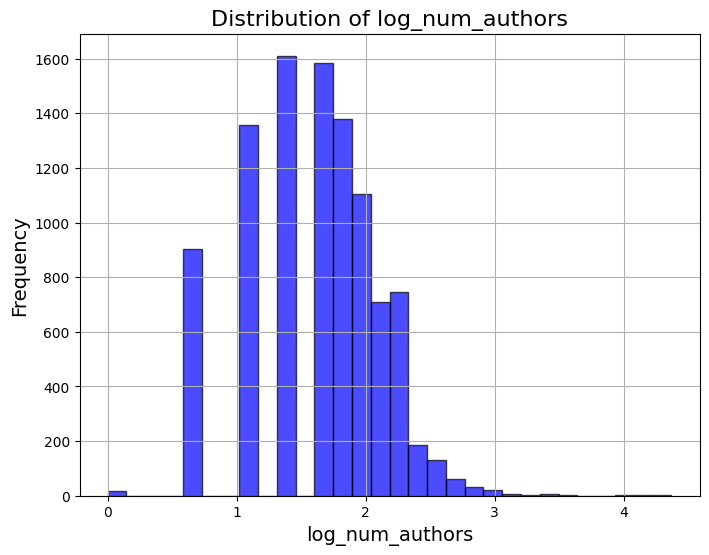

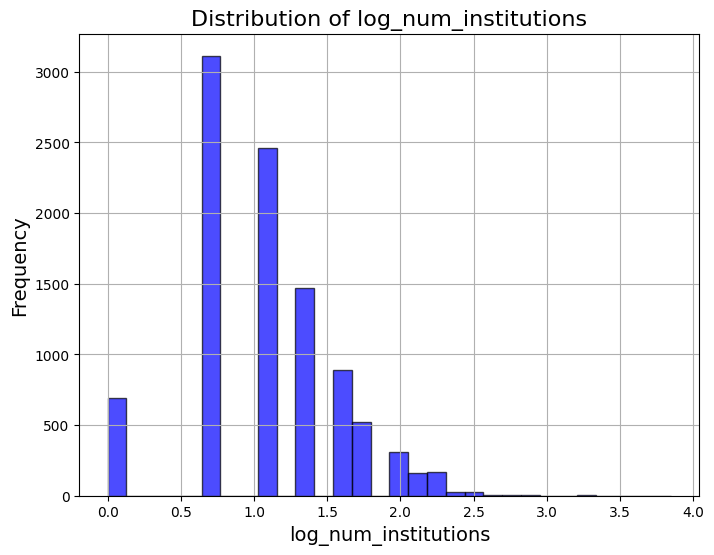

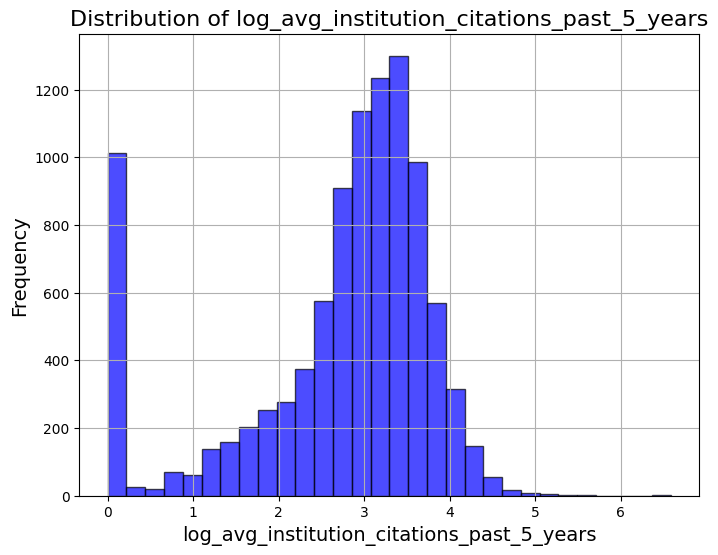

NameError: name 'y_initial' is not defined

<Figure size 800x600 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt

# List of variables to plot
variables = [
   "log_avg_author_citations_past_5_years", 
    "years_since_publication", 
    "log_journal_h_index", 
    "log_num_authors", 
    "log_num_institutions", 
    "log_avg_institution_citations_past_5_years",
]

# Loop through each variable in X_initial and plot its distribution
for var in variables:
    plt.figure(figsize=(8, 6))
    plt.hist(df[var], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Distribution of {var}", fontsize=16)
    plt.xlabel(var, fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(True)
    plt.show()

# Plot the distribution of the dependent variable y_initial
plt.figure(figsize=(8, 6))
plt.hist(y_initial, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title("Distribution of log_cited_by_count", fontsize=16)
plt.xlabel("log_cited_by_count", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True)
plt.show()

In [7]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file
# file_path = 'data_export.csv'
df = pd.read_csv("../../data/data_export.csv")

# Convert relevant columns to numeric and handle missing values
fields_to_convert = [
    "journal_h_index", "num_authors", "num_institutions",
    "cited_by_count", "publication_year", "avg_author_h_index", "max_author_h_index",
    "avg_institution_h_index", "max_institution_h_index", "avg_author_citations_past_5_years",
    "max_author_citations_past_5_years", "avg_institution_citations_past_5_years", 
    "max_institution_citations_past_5_years"
]
for field in fields_to_convert:
    df[field] = pd.to_numeric(df[field], errors="coerce").fillna(0)

# Convert publication_date to datetime
df["publication_date"] = pd.to_datetime(df["publication_date"], errors="coerce")

# Drop rows where cited_by_count is 0
df = df[df["cited_by_count"] > 0]

# Apply log transformation to all relevant variables
variables_to_log_transform = [
    "cited_by_count", 
    "avg_author_citations_past_5_years", 
    "avg_institution_citations_past_5_years", 
    "num_authors", 
    "num_institutions", 
    "journal_h_index"
]
for var in variables_to_log_transform:
    df[f"log_{var}"] = np.log1p(df[var])  # log(1 + variable)

# Calculate time since publication
df["years_since_publication"] = 2024 - df["publication_year"]

# Ensure there is a "predicted_category" column in the dataset
if "predicted_category" not in df.columns:
    raise ValueError("The dataset must contain a 'predicted_category' column.")

# Initialize a dictionary to store results for each category
category_results = {}

# Loop through each unique category in "predicted_category"
for category in df["predicted_category"].unique():
    df_category = df[df["predicted_category"] == category]  # Subset the data for the current category
    
    # Define independent (X) and dependent (y) variables using log-transformed versions where applicable
    X = df_category[[
        "log_avg_author_citations_past_5_years", 
        "years_since_publication", 
        "log_journal_h_index", 
        "log_num_authors", 
        "log_num_institutions", 
        "log_avg_institution_citations_past_5_years",
    ]]
    y = df_category["log_cited_by_count"]

    # Add a constant term to the independent variables
    X = sm.add_constant(X)

    # Fit the OLS regression model for the current category
    model = sm.OLS(y, X).fit()
    
    # Store the results
    category_results[category] = model

    # Print the summary for the current category
    print(f"Category: {category}")
    print(model.summary())
    print("\n" + "="*80 + "\n")

# Optionally, visualize or further process the category-specific results

Category: Physical Attributes
                            OLS Regression Results                            
Dep. Variable:     log_cited_by_count   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     518.5
Date:                Thu, 02 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:27:04   Log-Likelihood:                -4312.2
No. Observations:                3779   AIC:                             8638.
Df Residuals:                    3772   BIC:                             8682.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

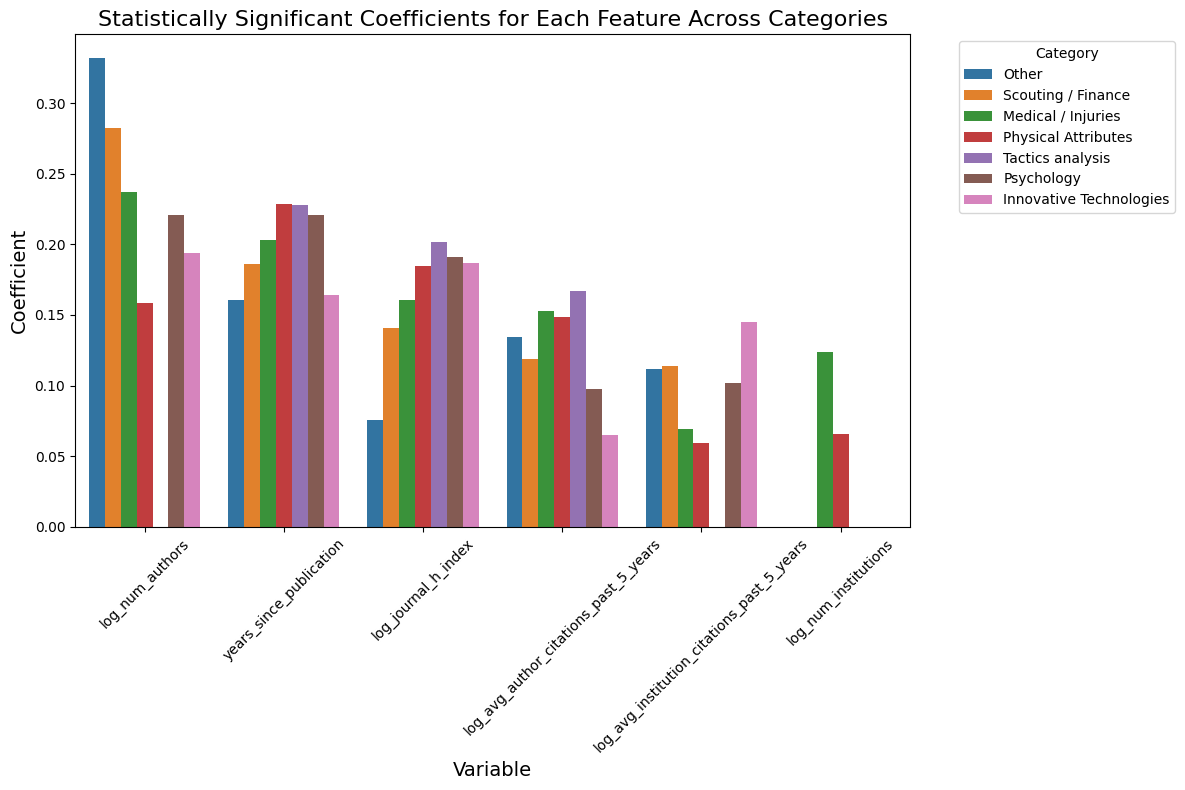

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare a DataFrame for visualization from category_results
visualization_data = []

# Iterate over category_results to extract coefficients and significance
for category, results in category_results.items():
    for variable in [
        "log_avg_author_citations_past_5_years",  # Use the log-transformed variable
        "years_since_publication", 
        "log_journal_h_index",  # Updated to log-transformed
        "log_num_authors",      # Updated to log-transformed
        "log_num_institutions", # Updated to log-transformed
        "log_avg_institution_citations_past_5_years"  # Updated to log-transformed
    ]:
        coef = results.params.get(variable, 0)  # Extract coefficient
        p_value = results.pvalues.get(variable, 1)  # Extract p-value
        is_significant = p_value < 0.05  # Check if p-value indicates significance

        # Append only significant coefficients
        if is_significant:
            visualization_data.append({
                "Category": category,
                "Variable": variable,
                "Coefficient": coef
            })

# Convert to DataFrame for plotting
coef_melted_with_significance = pd.DataFrame(visualization_data)

# Check if there is data to plot
if not coef_melted_with_significance.empty:
    # Sort the data to have a clean, ordered plot
    coef_melted_with_significance.sort_values(by="Coefficient", ascending=False, inplace=True)

    # Plot only significant coefficients
    plt.figure(figsize=(12, 8))  # Adjust for better readability

    sns.barplot(
        data=coef_melted_with_significance,
        x="Variable",
        y="Coefficient",
        hue="Category",
        dodge=True,
        palette="tab10"  # Use distinct colors for categories
    )

    # Title and labels
    plt.title("Statistically Significant Coefficients for Each Feature Across Categories", fontsize=16)
    plt.xlabel("Variable", fontsize=14)
    plt.ylabel("Coefficient", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    plt.show()
else:
    print("No significant coefficients to plot.")

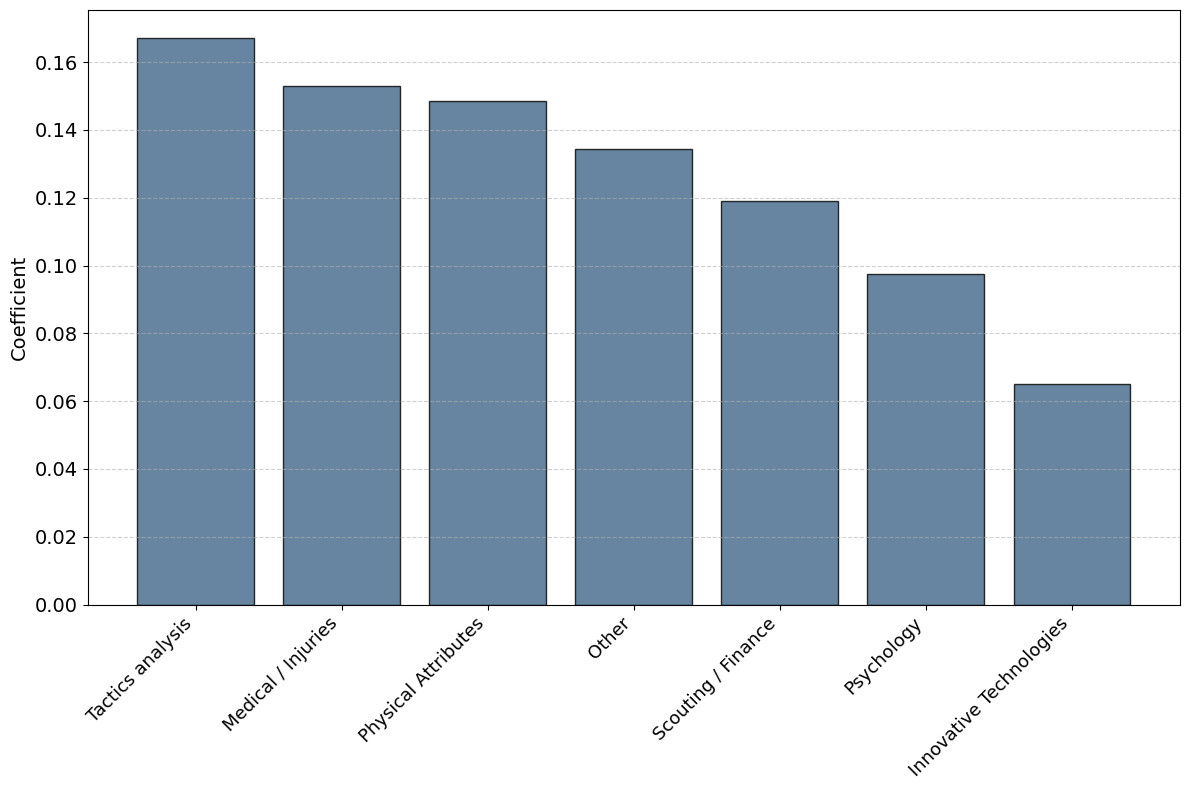

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Prepare a DataFrame for visualization from category_results
visualization_data = []

# Iterate over category_results to extract coefficients and significance for log_avg_author_citations_past_5_years
for category, results in category_results.items():
    variable = "log_avg_author_citations_past_5_years"  # Focus on this variable
    coef = results.params.get(variable, 0)  # Extract coefficient
    p_value = results.pvalues.get(variable, 1)  # Extract p-value
    is_significant = p_value < 0.05  # Check if p-value indicates significance

    # Append only significant coefficients
    if is_significant:
        visualization_data.append({
            "Category": category,
            "Coefficient": coef
        })

# Convert to DataFrame for plotting
coef_melted_with_significance = pd.DataFrame(visualization_data)

# Check if there is data to plot
if not coef_melted_with_significance.empty:
    # Sort data in descending order of coefficients and flip the order for bar plot
    coef_melted_with_significance = coef_melted_with_significance.sort_values(by="Coefficient", ascending=False)

    # Normalize coefficients for color mapping
    norm = mcolors.Normalize(vmin=coef_melted_with_significance["Coefficient"].min(),
                              vmax=coef_melted_with_significance["Coefficient"].max())
    color_map = cm.ScalarMappable(norm=norm, cmap="Blues")
    coef_melted_with_significance["Color"] = coef_melted_with_significance["Coefficient"].apply(
        lambda x: color_map.to_rgba(x))

    # Create the plot
    # fig, ax = plt.subplots(figsize=(12, 8))  # Adjust vertical space for better readability
    # for index, row in coef_melted_with_significance.iterrows():
    #     ax.barh(row["Category"], row["Coefficient"], color=row["Color"], edgecolor='black')

    # # Flip the order of the categories
    # ax.invert_yaxis()

    # Title and labels
  
    # Add color bar
    # sm = cm.ScalarMappable(cmap="Blues", norm=norm)
    # sm.set_array([])
    coef_melted_with_significance["Color"] = '#416788'
    # cbar = plt.colorbar(sm, ax=ax, orientation="vertical", label="Coefficient Magnitude")
    fig, ax = plt.subplots(figsize=(12, 8))  # Adjust vertical space for better readability
    for index, row in coef_melted_with_significance.iterrows():
        ax.bar(row["Category"], row["Coefficient"], color=row["Color"], edgecolor='black', alpha=0.8)

    # ax.set_title("Predicting log-Citations using log-Avg Co-Author Citations (limited to past 5 years)", fontsize=16)
    ax.set_ylabel("Coefficient", fontsize=14)
    plt.xticks(fontsize=13, rotation=45, ha='right')
    plt.yticks(fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    # ax.set_ylabel("Category", fontsize=14)
    plt.tight_layout()
    plt.savefig("linear_regression_log_citations.jpg", dpi=400)
    plt.show()
else:
    print("No significant coefficients to plot.")

In [11]:
coef_melted_with_significance[['Category', 'Coefficient']]

,Category,Coefficient
1,Tactics analysis,0.167013
2,Medical / Injuries,0.152830
0,Physical Attributes,0.148498
6,Other,0.134302
5,Scouting / Finance,0.118907
3,Psychology,0.097387
4,Innovative Technologies,0.065110
